# **Project Overview**

This project focuses on building and evaluating text classification models for automatic product categorization in e-commerce. Using a large-scale dataset of over 5 million product titles from Amazon marketplaces in the USA, Canada, and the UK, the goal is to predict the most appropriate product category based solely on the title text. The project explores category distributions, highlights challenges such as extreme class imbalance across 700+ categories, and compares the performance of traditional machine learning and deep learning models using different word embedding techniques. Through systematic experimentation and evaluation, the study aims to identify effective modeling approaches for scalable, accurate, and practical product title classification in real-world e-commerce systems.

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
plt.style.use("ggplot")



In [4]:
# Load dataset from Drive

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/titles_to_categories.csv')
print("Shape:", df.shape)
df.head(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape: (5389901, 2)


,title,category_name
0,"Green Leaf WW3D Wonder Extension Cord Winder, ...",Industrial Scientific
1,8pcs Toilet Seat Bumpers Universal Toilet Repl...,Industrial Scientific
2,YaeCCC 19 Pcs Hole Saw Kit 3/4''(19mm)- 6''(15...,Industrial Scientific
3,LLPT Butyl Putty Tape White 1 Inch x 33Ft Tigh...,Industrial Scientific
4,"Lightbeam 16"" Long Stem Deep Fry Thermometer w...",Industrial Scientific
5,"etguuds White USB C to USB C Cable [10ft, 2-Pa...",Industrial Scientific
6,REAQER CPAP Hose Holder Hanger for Preventing ...,Industrial Scientific
7,"SAVITA 2pcs Magnetic Bottle Openers, Can Tappe...",Industrial Scientific
8,Simba Lighting LED A19 Light Bulbs (4 Pack) 9W...,Industrial Scientific
9,"Knife Sharpening Stone,400/1000.2000/5000 Doub...",Industrial Scientific


In [5]:
# Inspect and Display basic information about the dataset
# Show column names and data types
print(df.info())

# Check missing values
print("\nMissing Values:\n", df.isnull().sum())

# Print column names
print("\nColumns:", df.columns)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5389901 entries, 0 to 5389900
Data columns (total 2 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   title          object
 1   category_name  object
dtypes: object(2)
memory usage: 82.2+ MB
None

Missing Values:
 title            0
category_name    0
dtype: int64

Columns: Index(['title', 'category_name'], dtype='object')


In [6]:
# Replace column names from dataset
TEXT_COL = "title"
LABEL_COL = "category_name"

# Preview text and labels
df[[TEXT_COL, LABEL_COL]].head()


,title,category_name
0,"Green Leaf WW3D Wonder Extension Cord Winder, ...",Industrial Scientific
1,8pcs Toilet Seat Bumpers Universal Toilet Repl...,Industrial Scientific
2,YaeCCC 19 Pcs Hole Saw Kit 3/4''(19mm)- 6''(15...,Industrial Scientific
3,LLPT Butyl Putty Tape White 1 Inch x 33Ft Tigh...,Industrial Scientific
4,"Lightbeam 16"" Long Stem Deep Fry Thermometer w...",Industrial Scientific


In [7]:
# Count unique categories
num_classes = df[LABEL_COL].nunique()
print("Number of categories:", num_classes)


Number of categories: 726


# **Class Distribution**

count       726.000000
mean       7424.106061
std       27082.071396
min          12.000000
25%        1739.250000
50%        6128.000000
75%        8704.750000
max      720050.000000
Name: count, dtype: float64


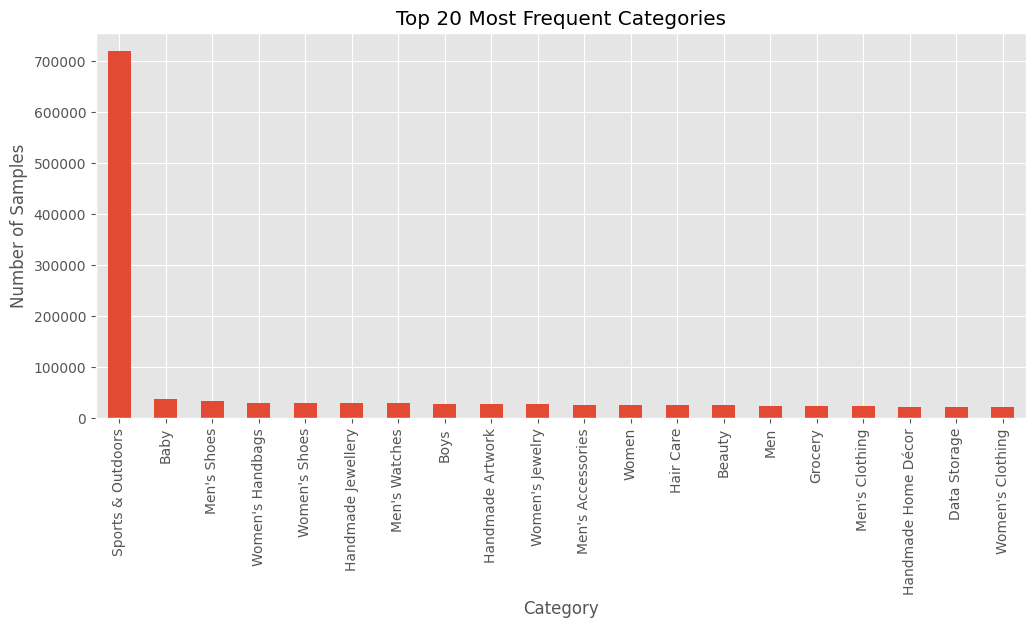

Number of rare classes (<50 samples): 7


In [8]:
# Count samples per category
class_counts = df[LABEL_COL].value_counts()

print(class_counts.describe())

# Plot top 20 most frequent categories
plt.figure(figsize=(12,5))
class_counts.head(20).plot(kind="bar")
plt.title("Top 20 Most Frequent Categories")
plt.xlabel("Category")
plt.ylabel("Number of Samples")
plt.show()

# Count rare categories (less than 50 samples)
rare_classes = (class_counts < 50).sum()
print("Number of rare classes (<50 samples):", rare_classes)


**Insight from Visualization :** The class distribution analysis reveals a highly imbalanced, long-tail dataset where a small number of categories dominate while many others have limited samples. Relying solely on accuracy would therefore give a misleading picture of model performance, as it favors majority classes. To ensure fair and robust evaluation across all categories, balanced metrics such as macro-F1 and weighted-F1 are necessary, as they account for minority class performance. Additionally, applying class weighting during training helps reduce majority-class bias and improves the model’s ability to learn meaningful patterns from underrepresented categories, leading to more reliable and generalizable classification results.

# **Text Length Analysis**

count    5.389901e+06
mean     1.862198e+01
std      7.957540e+00
min      1.000000e+00
25%      1.200000e+01
50%      1.900000e+01
75%      2.500000e+01
max      3.050000e+02
Name: text_length, dtype: float64


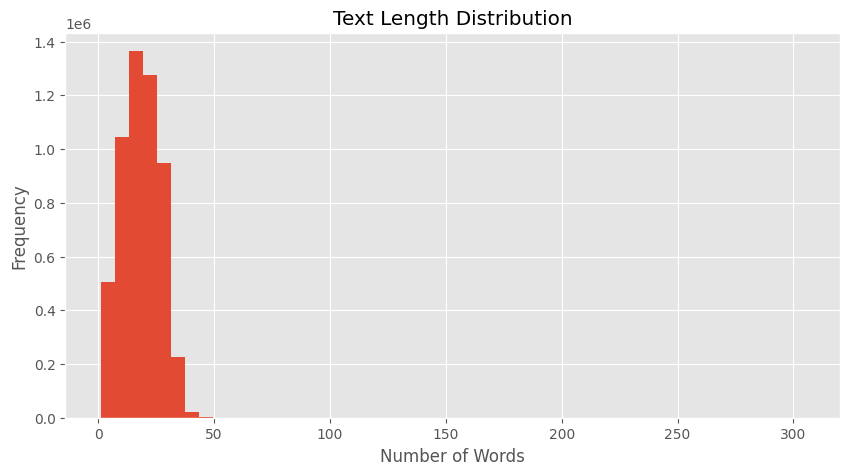

In [9]:
# Compute number of words per title
df["text_length"] = df[TEXT_COL].astype(str).apply(lambda x: len(x.split()))

# Summary statistics
print(df["text_length"].describe())

# Plot distribution
plt.figure(figsize=(10,5))
plt.hist(df["text_length"], bins=50)
plt.title("Text Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


**Insight from the Text Length Distribution**

The distribution shows that most product titles are very short, with the majority containing fewer than 40–50 words, and a strong concentration at the lower end of the scale. This confirms that product titles are concise and highly structured, rather than long, descriptive texts. The long right tail indicates the presence of a small number of unusually long titles, which are likely outliers or noisy entries.

In [10]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return text

df["clean_text"] = df[TEXT_COL].apply(clean_text)


# **Vocabulary and Word Frequency**


Vocabulary size: 1953663


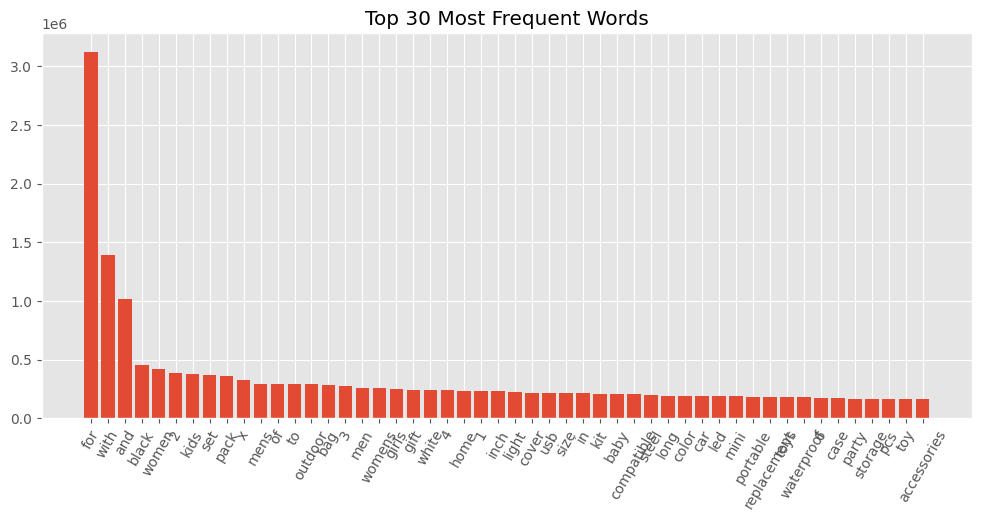

In [11]:
# Combine all text
all_words = " ".join(df["clean_text"]).split()

# Count word frequency
word_freq = Counter(all_words)

print("Vocabulary size:", len(word_freq))

# Most common words
common_words = word_freq.most_common(50)
words, counts = zip(*common_words)

plt.figure(figsize=(12,5))
plt.bar(words, counts)
plt.xticks(rotation=60)
plt.title("Top 30 Most Frequent Words")
plt.show()


**Insight from Vocabulary and Word Frequency:** The vocabulary analysis revealed a highly skewed distribution, where a small set of frequent tokens dominates while the majority of words appear rarely. This indicates high lexical diversity and the presence of many product-specific or low-frequency terms. To address sparsity and improve efficiency, vocabulary limiting and embedding-based representations are necessary, as they capture meaningful relationships among commonly occurring descriptive tokens while mitigating the impact of rare words.

**Rare Words & Vocabulary Coverage**

In [12]:
rare_words = sum(1 for w, c in word_freq.items() if c < 5)

print("Rare words:", rare_words)
print("Rare word percentage:", rare_words / len(word_freq))


Rare words: 1666160
Rare word percentage: 0.8528390003803112


In [13]:
duplicates = df[TEXT_COL].duplicated().sum()
print("Number of duplicate titles:", duplicates)


Number of duplicate titles: 0


**Numeric Token Detection**

In [14]:
def has_number(text):
    return bool(re.search(r"\d", str(text)))

df["has_number"] = df[TEXT_COL].apply(has_number)

print(df["has_number"].value_counts(normalize=True))


has_number
True     0.719015
False    0.280985
Name: proportion, dtype: float64


**Samples per Class Distribution**

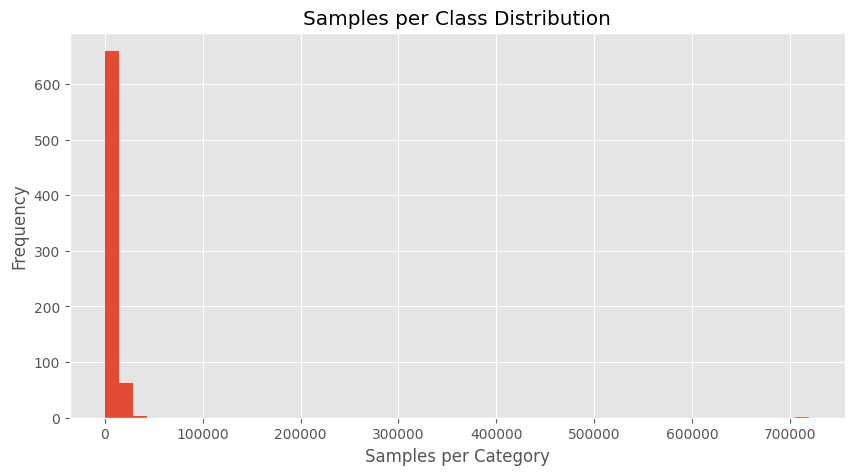

Mean samples per class: 7424.106060606061
Median samples per class: 6128.0


In [15]:
plt.figure(figsize=(10,5))
plt.hist(class_counts.values, bins=50)
plt.title("Samples per Class Distribution")
plt.xlabel("Samples per Category")
plt.ylabel("Frequency")
plt.show()

print("Mean samples per class:", class_counts.mean())
print("Median samples per class:", class_counts.median())


**Insight:** The samples-per-class analysis reveals a pronounced long-tail distribution, with most categories having limited samples and a small number of dominant categories containing orders of magnitude more data. This imbalance increases model bias toward frequent classes and necessitates the use of class weighting and balanced evaluation metrics to achieve robust multi-class performance.